In [3]:
import numpy as np
import skimage.io as io
from skimage.morphology import disk
from skimage.morphology import binary_dilation, binary_erosion
import matplotlib.pyplot as plt
import time
import math as m
from skimage.transform import resize
from skimage import img_as_bool
from skimage.measure import label
import cv2

In [4]:
def reorder_label (lbl):
    ret = np.zeros_like (lbl)
    val_list = np.unique (lbl).tolist ()
    if val_list [0] != 0:
        for i in range (len (val_list)):
            if val_list [i] == 0:
                val_list.pop (i)
                val_list = [0] + val_list
                break
    for i, val in enumerate (val_list):
        if val == 0:
            continue
        ret [lbl == val] = i
    return ret.astype (np.int8, copy=False)


def relabel (lbl):
    ret = np.zeros (lbl.shape, dtype=np.int32)
    cur_max_val = 0
    val_list = np.unique (lbl)
    for val in val_list:
        if (val == 0):
            continue
        mask = (lbl == val)
        sub_lbl = label (mask, connectivity=1).astype (np.int32)

        sub_lbl += cur_max_val * (sub_lbl > 0)
        ret += sub_lbl
        cur_max_val = np.max (ret)
    return ret

In [5]:
# label_ds = io.imread ("../Data/CVPPP_Challenge/train/B/train_set_B.tif")
label_ds = io.imread ("../Data/snemi/train/B/train-labels.tif")

In [11]:
def budget_binary_dilation (img, radius):
    fac = 2
    ori_shape = img.shape
    img = img [::fac,::fac]
    img = binary_dilation (img, disk (radius // fac))
    img = img_as_bool (resize (img.astype (np.int8), ori_shape, order=cv2.INTER_NEAREST, anti_aliasing=False, mode='reflect'))
    return img

def budget_binary_erosion (img, fac):
    area = m.sqrt (np.count_nonzero (img))
    inr = binary_erosion (img)
    while (m.sqrt (np.count_nonzero (inr)) > fac * area):
        inr = binary_erosion (inr)
    return inr

In [17]:
img_id = 44
radius = 32
print (np.unique (label_ds [img_id][::2, ::2][:256,:256]))
img =  relabel (reorder_label (label_ds [img_id][::2, ::2][:256,:256]))
lbl = [img == id for id in np.unique (img)]
segs = [seg for seg in lbl]
curtime = time.time ()
bdrs = [seg ^ budget_binary_dilation (seg, radius) for seg in segs]
inrs = [budget_binary_erosion (seg, 0.9) for seg in segs]
print (time.time () - curtime)

[  0   6   9  10  12  15  17  18  22  23  24  41  42  43  48  51  52  55
  63  64  66  67  70  71  74  86  88  89  90  94  97  99 100 101 111 121
 125 126 151 159 165 189 192 193 204 205 206 207 212 213 214 215 217 218
 219 238 239 240 256 258 260 273 275 289 301 302 328 329 331 332 357 358
 369 394]
2.7752628326416016


In [18]:
print (len (segs))

94


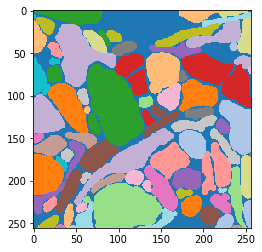

In [19]:
plt.imshow (img, cmap='tab20')
plt.show ()

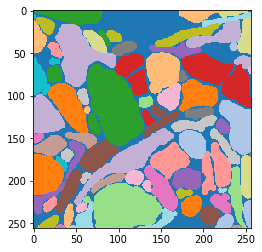

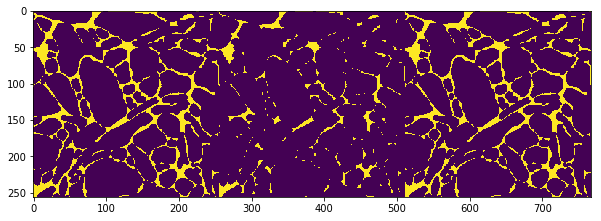

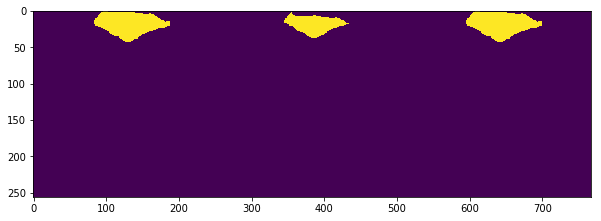

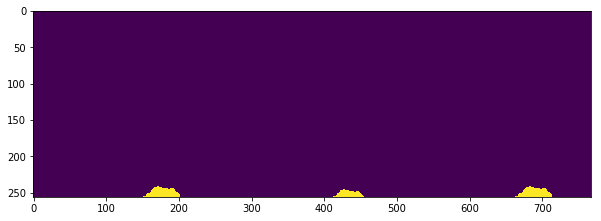

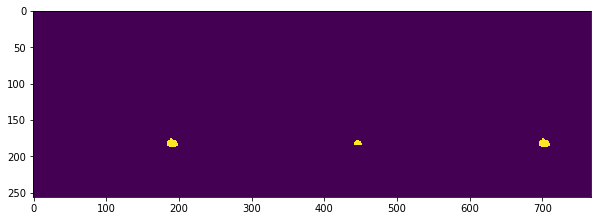

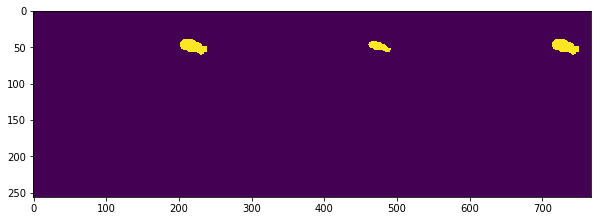

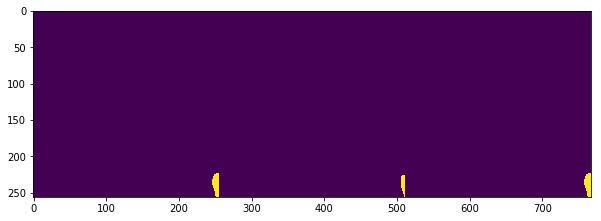

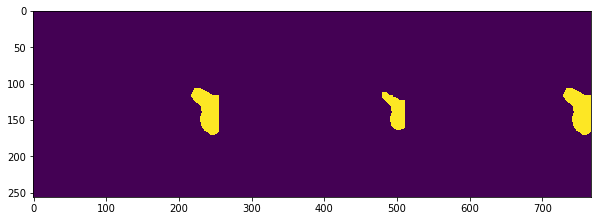

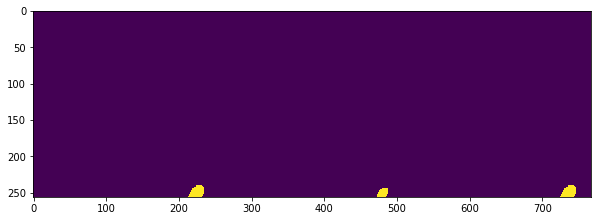

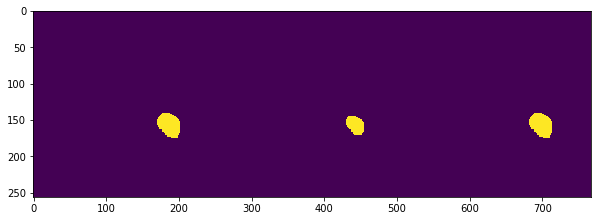

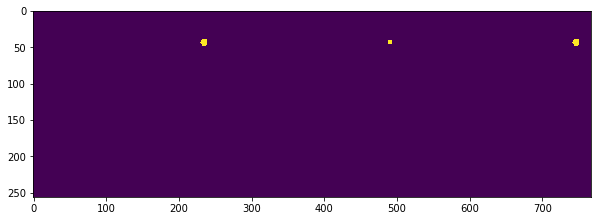

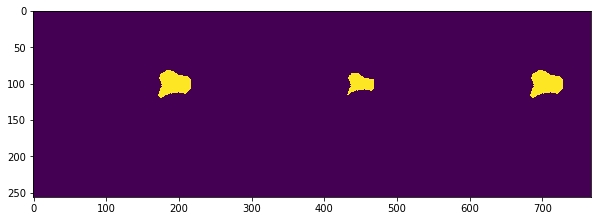

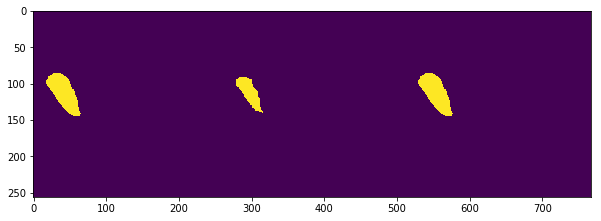

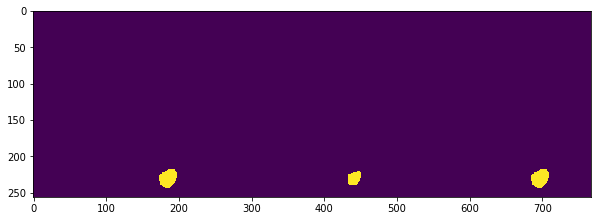

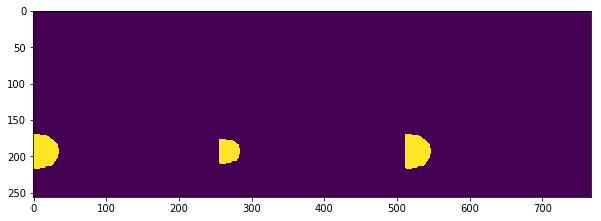

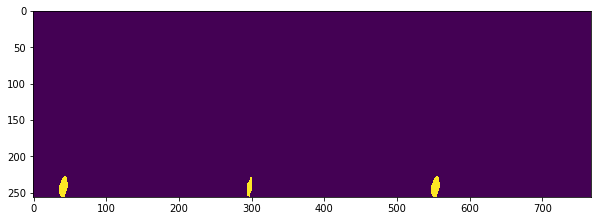

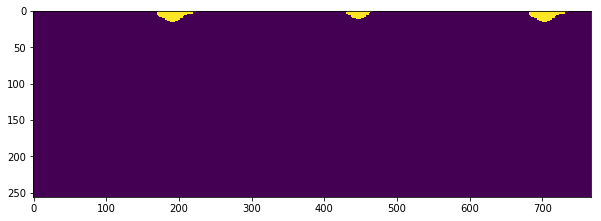

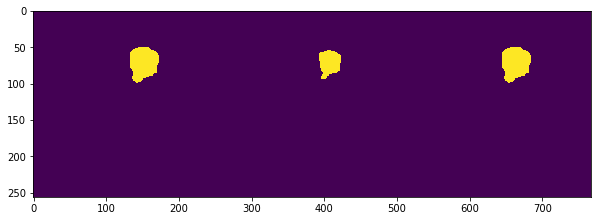

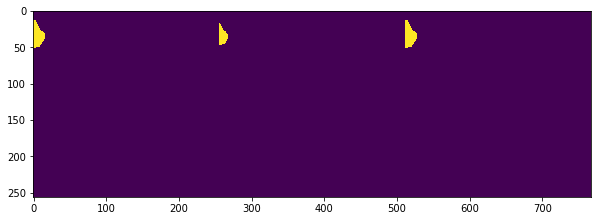

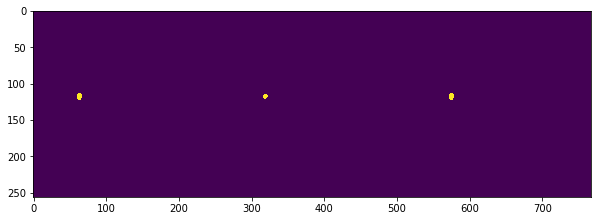

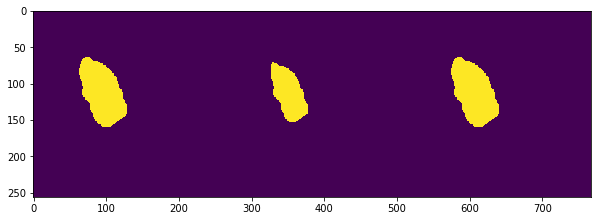

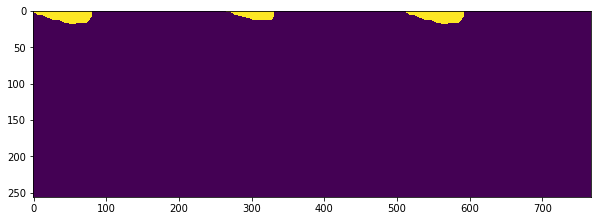

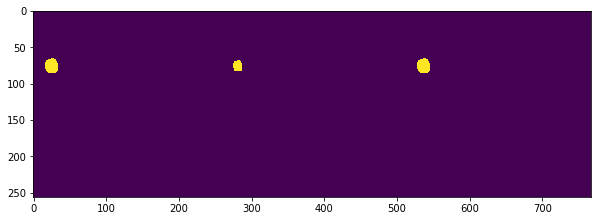

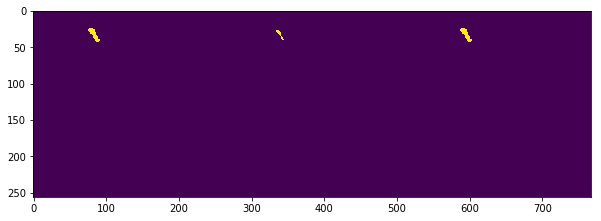

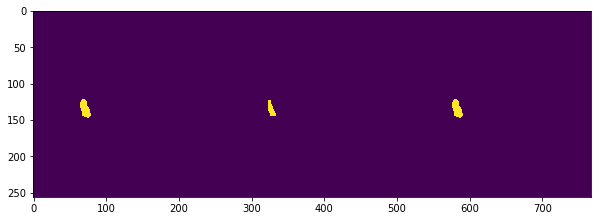

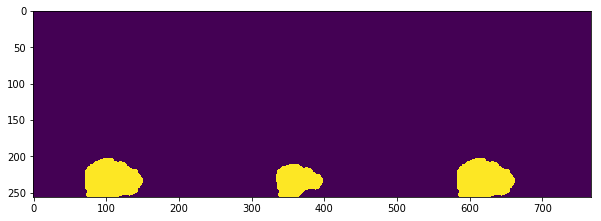

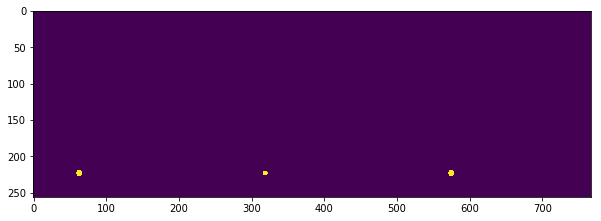

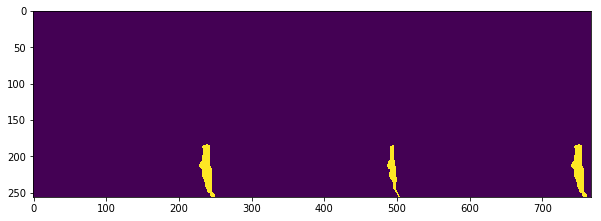

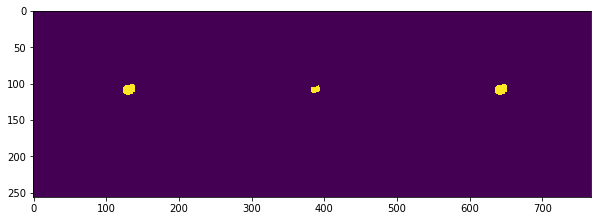

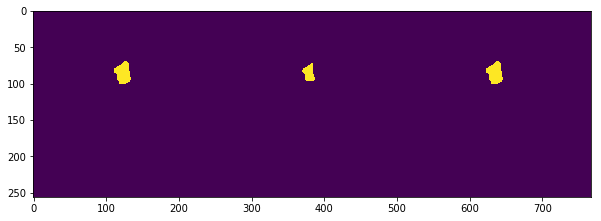

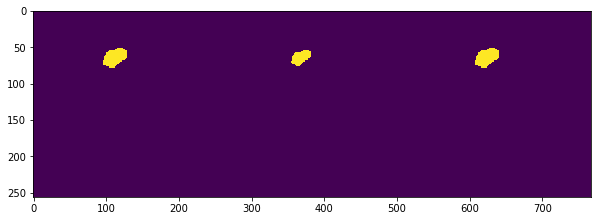

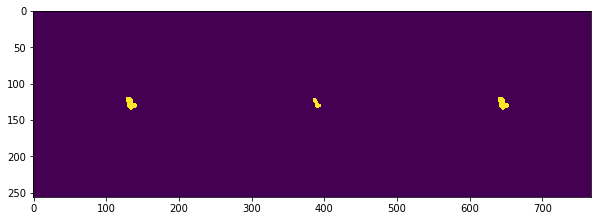

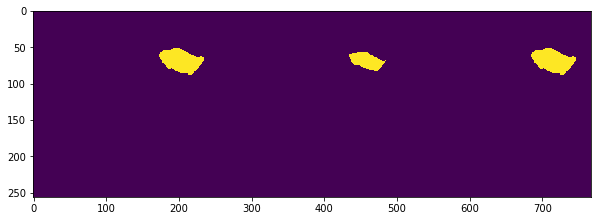

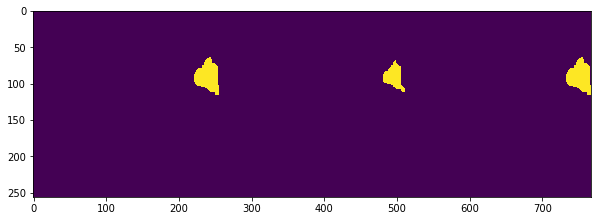

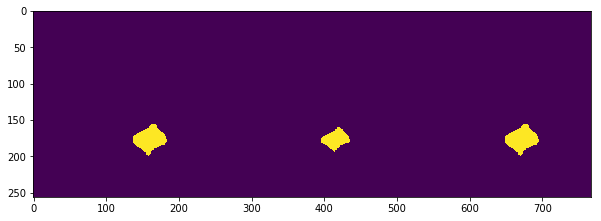

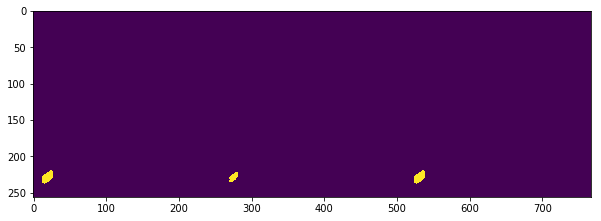

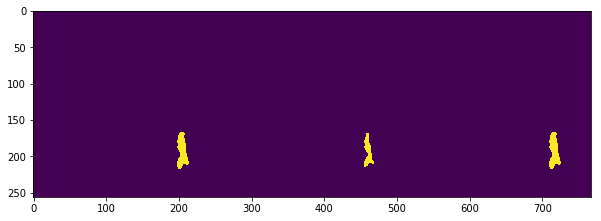

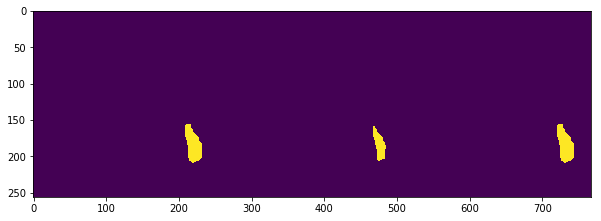

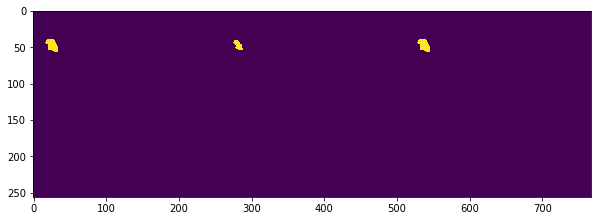

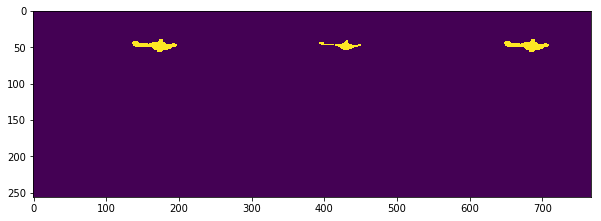

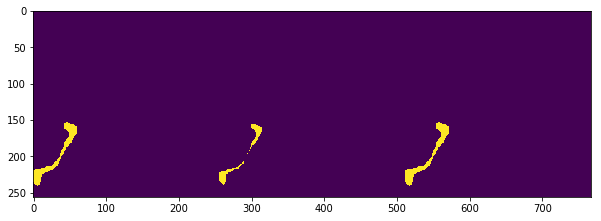

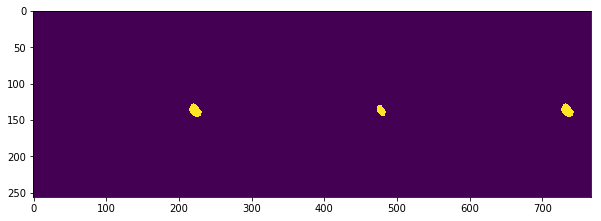

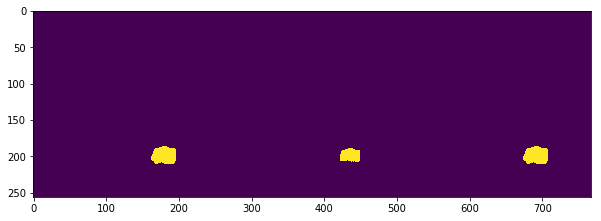

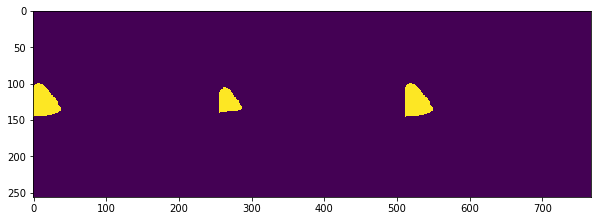

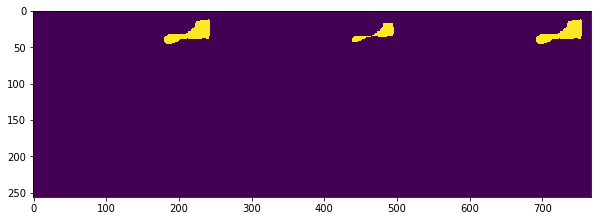

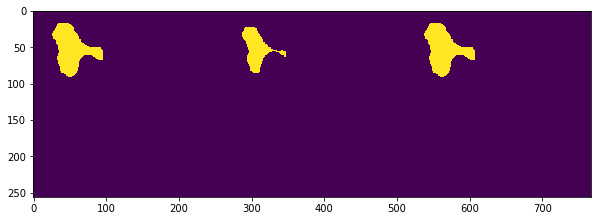

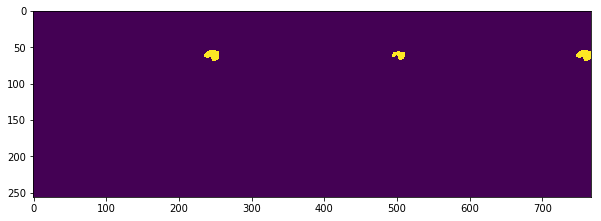

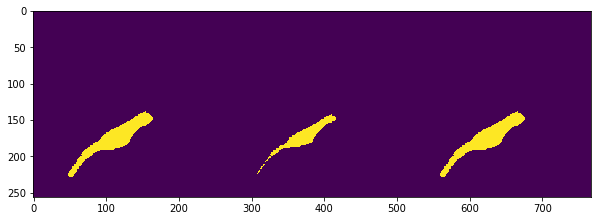

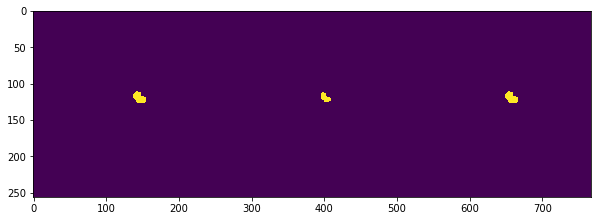

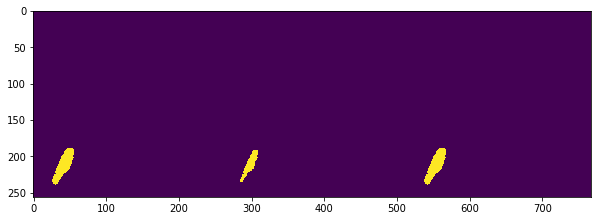

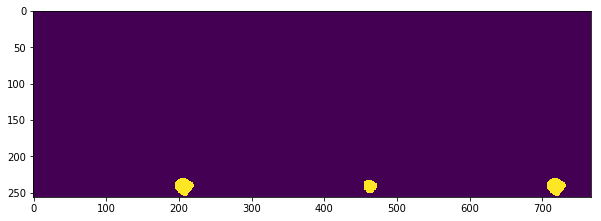

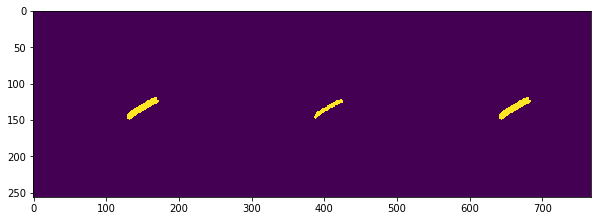

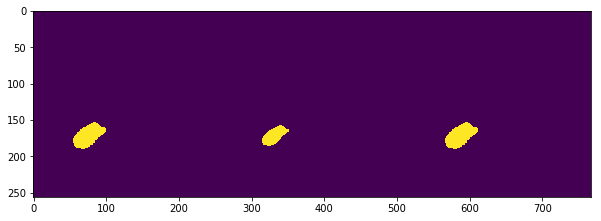

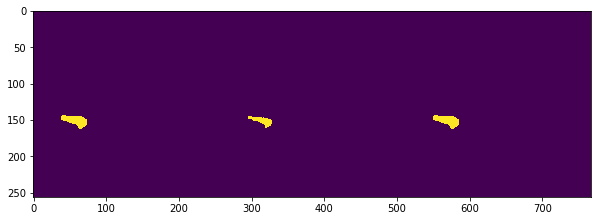

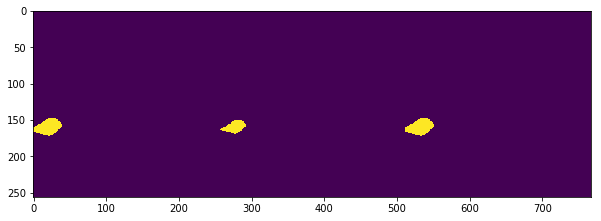

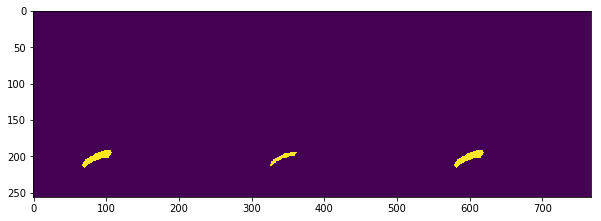

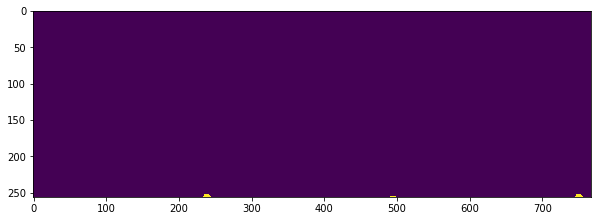

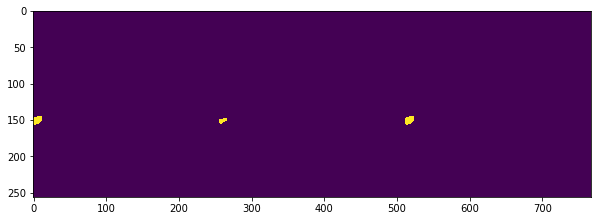

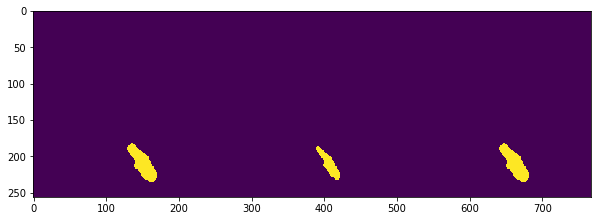

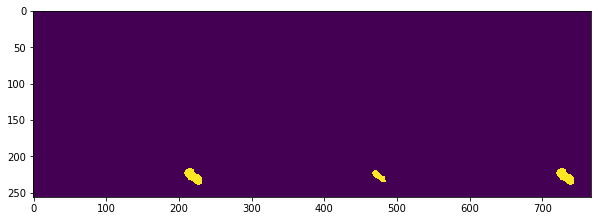

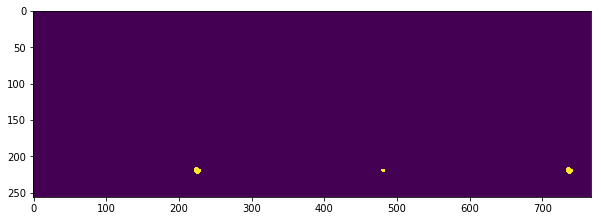

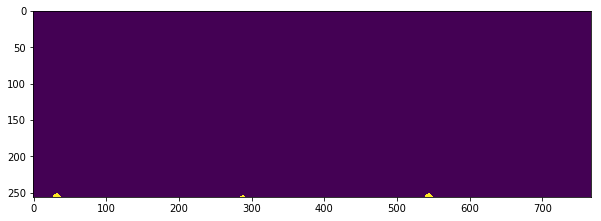

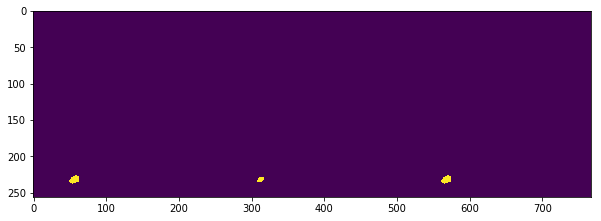

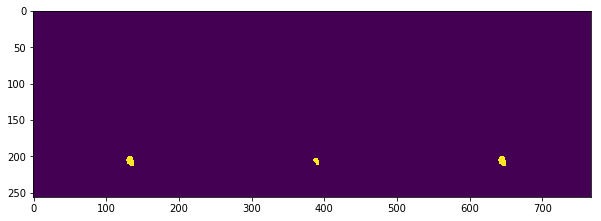

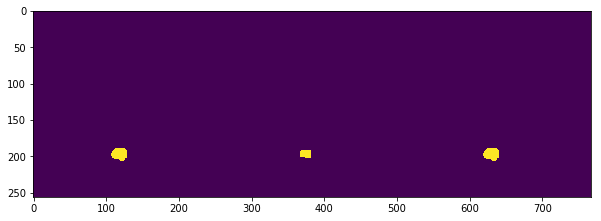

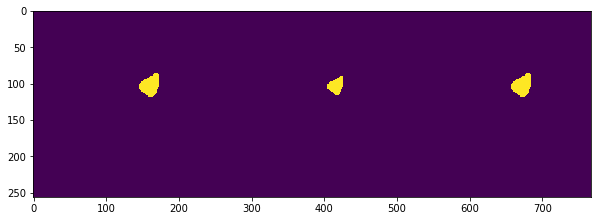

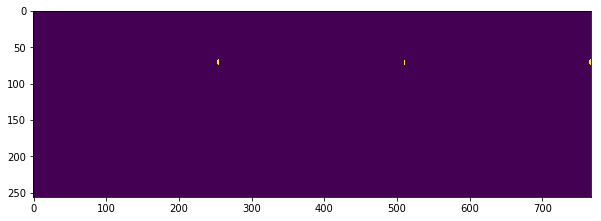

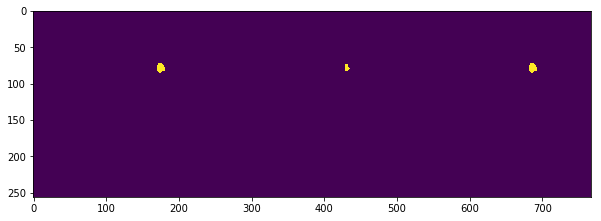

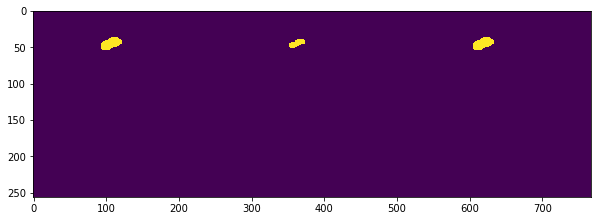

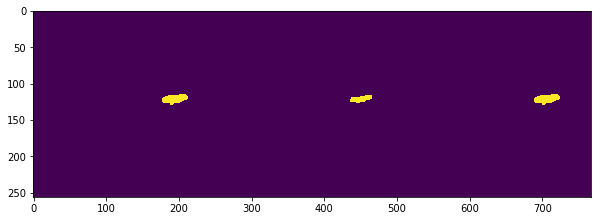

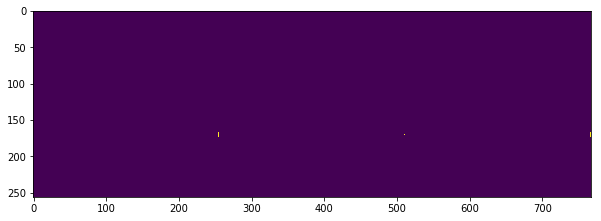

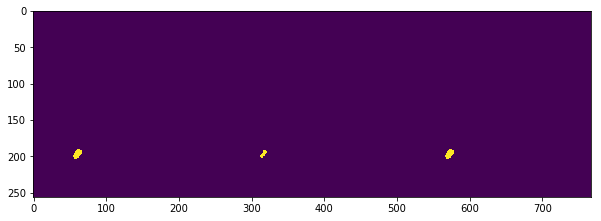

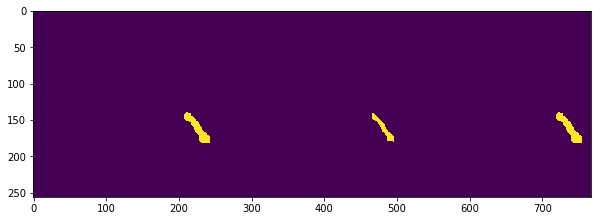

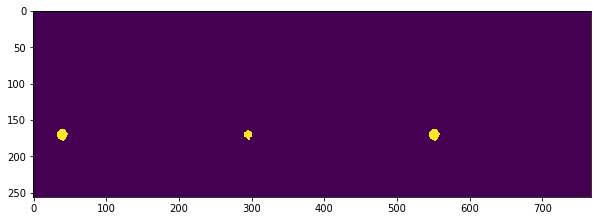

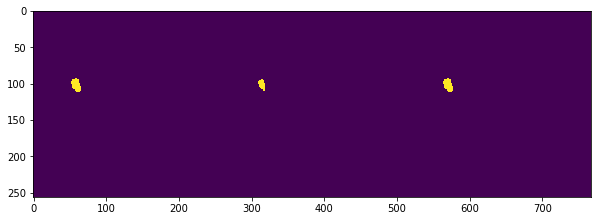

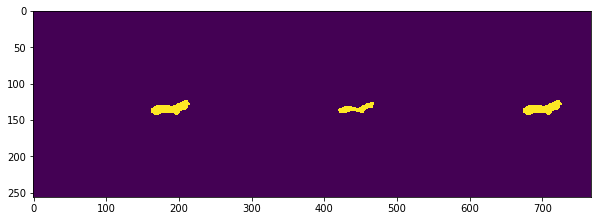

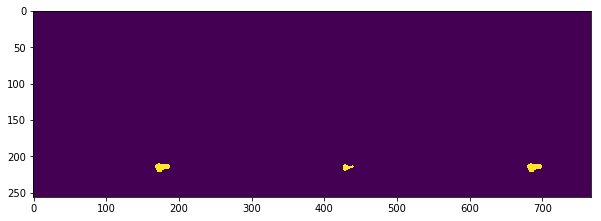

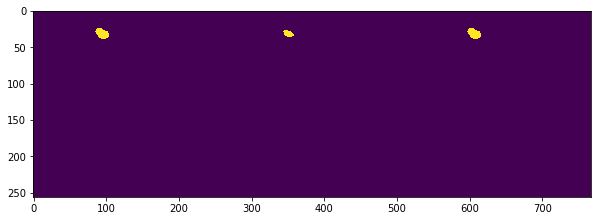

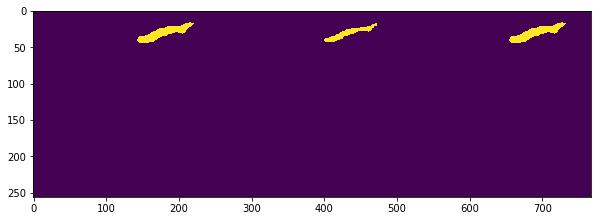

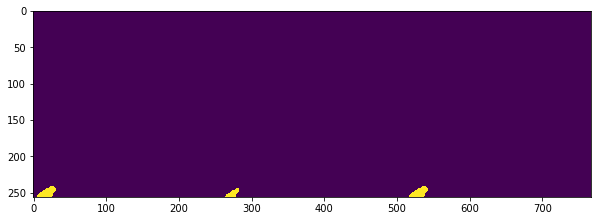

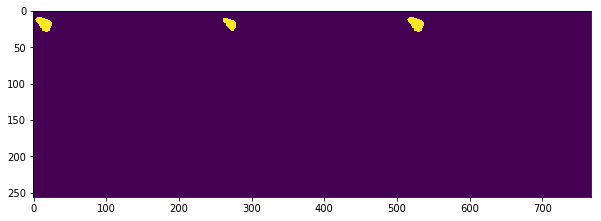

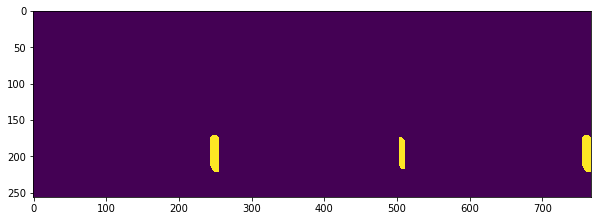

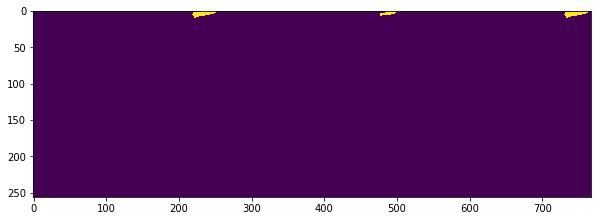

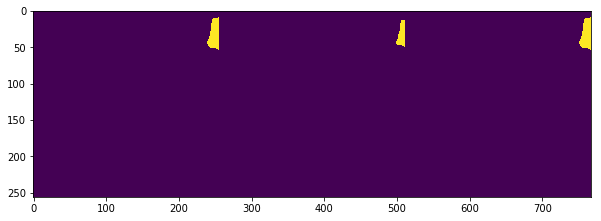

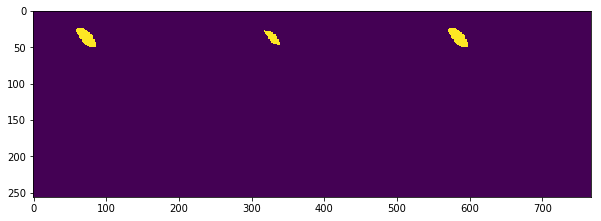

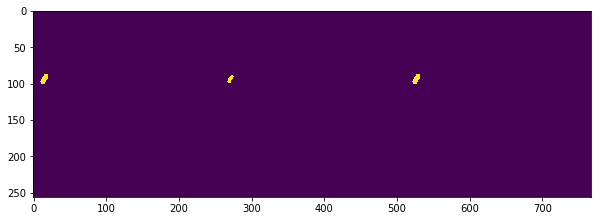

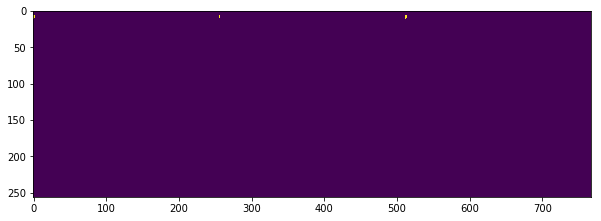

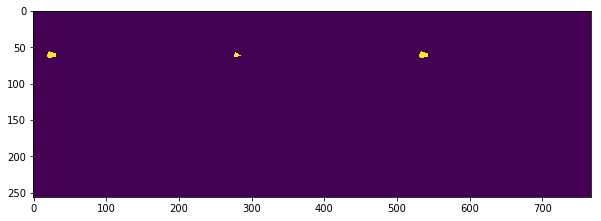

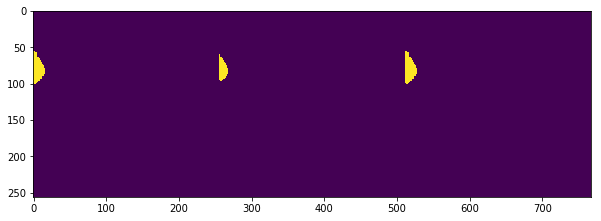

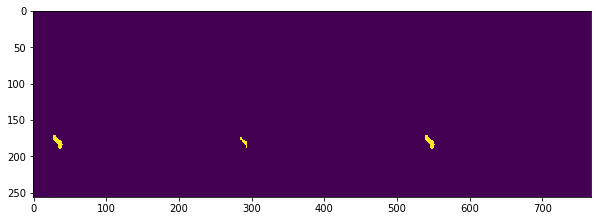

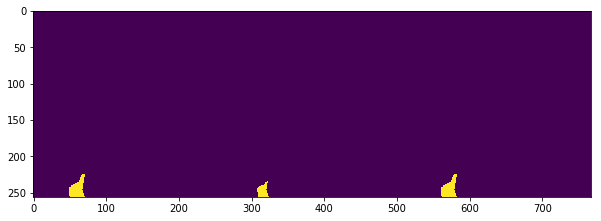

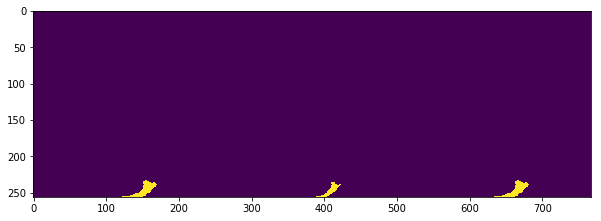

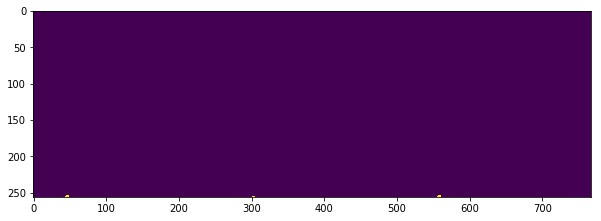

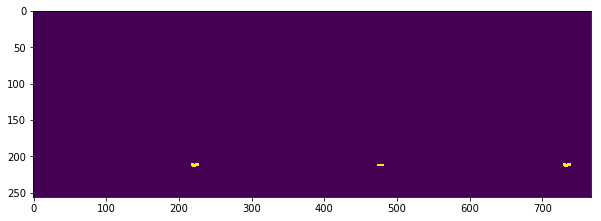

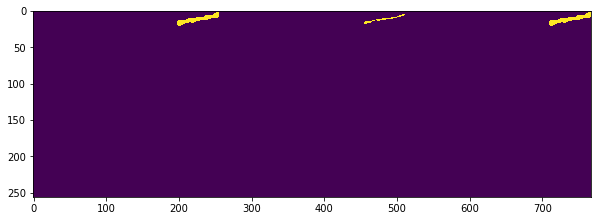

In [16]:
plt.imshow (img, cmap='tab20')
plt.show ()
for i in range (len (segs)):
    plt.figure (figsize=(10, 10))
    plt.imshow (np.concatenate ([segs [i], inrs[i], bdrs [i]], 1))
#     plt.imshow (np.concatenate ([segs [i]], 1))  
    plt.show ()

In [124]:


def bdr_cnt_mask (bdr, seg, bdr_sum, T):
    bdr_cnt = np.array ([0] * ((2**T) + 1))
    bdr_uni = np.unique (bdr, return_counts=True)
    for i in range (len(bdr_uni [0])):
        bdr_cnt [bdr_uni [0][i]] = bdr_uni[1][i]
    _bdr_cnt = bdr_sum - bdr_cnt
    _bdr_cnt [-1] = bdr_cnt [-1] = 0

    return (bdr_cnt [seg].astype (np.int32, copy=False), _bdr_cnt [seg].astype (np.int32, copy=False))
    
def split_reward (old_lbl, lbl, gt_lbl, first_step, T):
    t_spl_rew = np.zeros (lbl.shape, dtype=np.float32) #True split reward
    f_mer_pen = np.zeros (lbl.shape, dtype=np.float32) #False merge penalty

    for i in np.unique (gt_lbl):
        if i == 0:
            continue
        out1 = (True ^ segs [i]) # exclude only segment
        out2 = (True ^ bdrs[i]) # exclude segment and outter radius area
        bdr = bdrs [i] * lbl; seg = segs [i] * lbl 
        o_bdr = bdrs[i] * old_lbl; o_seg = segs [i] * old_lbl 
        bdr [(gt_lbl==0)|out2] = (2 ** T); seg [(gt_lbl==0)|out1] = (2 ** T)
        o_bdr [(gt_lbl==0)|out2] = (2 ** T); o_seg [(gt_lbl==0)|out1] = (2 ** T)
        
        bdr_sum = np.count_nonzero (bdrs[i] * gt_lbl) #Total non background pixels in bdr 
        bdr_cnt, _bdr_cnt = bdr_cnt_mask (bdr, seg, bdr_sum, T) # #of sames, diffs count in each pixel of inner
        o_bdr_cnt, _o_bdr_cnt = bdr_cnt_mask (o_bdr, o_seg, bdr_sum, T)

        t_spl_rew += (_bdr_cnt - _o_bdr_cnt) / bdr_sum
        f_mer_pen += bdr_cnt / (bdr_sum * T)
        
    ret = t_spl_rew - f_mer_pen
    return ret.astype (np.float32, copy=False)

def inr_cnt_mask (seg, inr_sum, T, debug=False):
    inr_cnt = np.array ([0] * ((2**T) + 1))
    inr_uni = np.unique (seg, return_counts=True)
    for i in range (len (inr_uni [0])):
        inr_cnt [inr_uni [0][i]] = inr_uni [1][i]

    _inr_cnt = inr_sum - inr_cnt
    _inr_cnt [-1] = inr_cnt [-1] = 0

    return (inr_cnt [seg].astype (np.int32, copy=False), _inr_cnt [seg].astype (np.int32, copy=False)) 
    
def merge_reward (old_lbl, lbl, gt_lbl, first_step, T):
    t_mer_rew = np.zeros (lbl.shape, dtype=np.float32)
    f_spl_pen = np.zeros (lbl.shape, dtype=np.float32)
    
    for i in np.unique (gt_lbl):
        if i == 0:
            continue
        out1 = (True ^ segs [i]) # exclude only segment
        seg = segs [i] * lbl 
        o_seg = segs [i] * old_lbl
        seg [(gt_lbl==0)|out1] = (2 ** T)
        o_seg [(gt_lbl==0)|out1] = (2 ** T)
        
        inr_sum = np.count_nonzero (segs[i] * gt_lbl) #Total non background pixels in seg 
        if (i == 3):
            print (inr_sum)
        inr_cnt, _inr_cnt = inr_cnt_mask (seg, inr_sum, T, i==3)
        o_inr_cnt, _o_inr_cnt = inr_cnt_mask (o_seg, inr_sum, T)
    
        t_mer_rew += inr_cnt / (inr_sum * T)
        f_spl_pen += (_inr_cnt - _o_inr_cnt) / inr_sum
    
    ret = t_mer_rew - f_spl_pen
    return ret.astype (np.float32, copy=False)

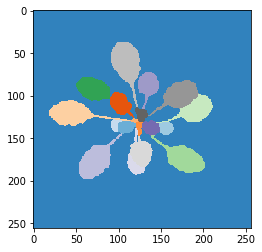

___________________________________________________
118
1.0 -0.25


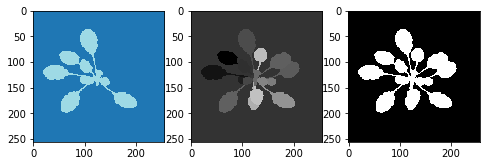

___________________________________________________
118
1.0 -0.23925139


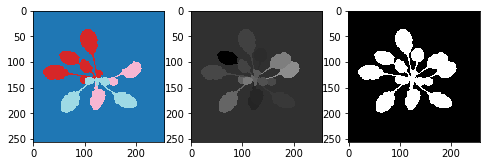

___________________________________________________
118
1.0 -0.037214883


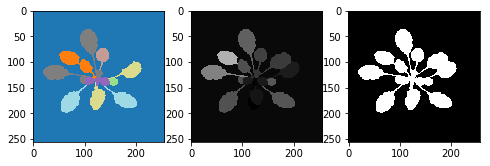

___________________________________________________
118
1.0 -0.06310066


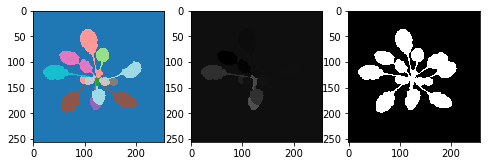

___________________________________________________
2.8032164573669434


In [6]:
state = np.zeros ((256, 256), dtype=np.int32)
img = img.astype (np.int32)
plt.imshow (img, cmap='tab20c')
plt.show ()
print ("___________________________________________________")
np.random.seed (1)
currtime = time.time ()
for i in range (4):
    new_state = np.copy (state)
    for val in np.unique (img):
        if (val == 0):
            continue
        if 0.5 > np.random.rand ():
            new_state += (2**i) * (val == img)
    split_rew = split_reward (state, new_state, img, (i==0), 4)
    merge_rew = merge_reward (state, new_state, img, (i==0), 4)
    fig=plt.figure(figsize=(8, 8))
    split_rew [0,0] = 1.0
    split_rew [0,1] = 0.0
    fig.add_subplot(1, 3, 1);    plt.imshow (new_state, cmap='tab20');
    fig.add_subplot(1, 3, 2);    plt.imshow (split_rew, cmap='gray')
    fig.add_subplot(1, 3, 3);    plt.imshow (merge_rew, cmap='gray')
    
    print (np.max (split_rew), np.min (split_rew))
    plt.show ()
    print ("___________________________________________________")
    state = new_state
print (time.time () - currtime)